In [1]:
# !pip install pytorch-lightning==2.1.4
# !pip install wandb

In [2]:
from datasets import load_dataset, Features, Array3D, Array2D
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pL
from pytorch_lightning.loggers import WandbLogger
import numpy as np
import wandb
from PIL import Image
import matplotlib.pyplot as plt
from itertools import islice
from pytorch_lightning.callbacks import LearningRateMonitor

In [3]:
wandb.login()

wandb: Currently logged in as: peryaudo. Use `wandb login --relogin` to force relogin


True

In [23]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, has_max_pool=True):
        super().__init__()
        self.has_max_pool = has_max_pool
        if self.has_max_pool:
            self.max_pool = nn.MaxPool2d(2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding='same')
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        if self.has_max_pool:
            x = self.max_pool(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, 2, 2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding='same')
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    
    def forward(self, x, resid):
        x = F.relu(self.up_conv(x))
        assert x.shape == resid.shape
        x = torch.cat((resid, x), dim=1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x
    
class SelfAttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, num_pos):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.pos_embed = nn.Embedding(num_pos, embed_dim)
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.register_buffer('pos', torch.arange(0, num_pos))
        
    def forward(self, x):
        x_shape = x.shape
        # [B,C,H,W] -> [B,C,H*W] -> [H*W,B,C]
        x = torch.flatten(x, start_dim=2).permute(2, 0, 1)
        # [H*W,B,C] + [H*W,1,C]
        x = x + self.pos_embed(self.pos.view(-1, 1))
        x = self.ln1(x)
        x, _ = self.self_attn(x, x, x)
        x = self.ln2(x)
        # [H*W,B,C] -> [B,C,H*W]
        x = x.permute(1, 2, 0)
        # [B,C,H*W] -> [B,C,H,W]
        x = x.view(x_shape)
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc0 = EncoderBlock(1, 64, has_max_pool=False)
        self.enc1 = EncoderBlock(64, 128)
        self.enc2 = EncoderBlock(128, 256)
        self.enc3 = EncoderBlock(256, 512)
        self.enc4 = EncoderBlock(512, 1024)
        self.dec4 = DecoderBlock(1024, 512)
        self.dec3 = DecoderBlock(512, 256)
        self.dec2 = DecoderBlock(256, 128)
        self.dec1 = DecoderBlock(128, 64)
        self.head = nn.Conv2d(64, 2, 1, padding='same')

        self.attn = SelfAttentionBlock(1024, num_heads=8, num_pos=16)
        

    def forward(self, x):
        x0 = self.enc0(x)
        x1 = self.enc1(x0)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x = self.enc4(x3)
        
        x = self.attn(x)
        x = self.dec4(x, x3)
        x = self.dec3(x, x2)
        x = self.dec2(x, x1)
        x = self.dec1(x, x0)
        x = self.head(x)
        x = torch.sigmoid(x)
        return x

In [5]:
def transforms(examples):
    image = examples["image"]
    hsv = np.array(image.resize((64,64)).convert("HSV"))
    examples["hs"] = hsv[:,:,0:-1].transpose(2, 0, 1).astype(np.float32) / 255.0
    examples["v"] =  hsv[:,:,-1][None,].astype(np.float32) / 255.0 - 0.5
    return examples

features = Features({
    "hs": Array3D(dtype="float32", shape=(2, 64, 64)),
    "v": Array3D(dtype="float32", shape=(1, 64, 64)),
})

dataset = load_dataset("huggan/flowers-102-categories", cache_dir="/storage/.cache/huggingface/datasets")
dataset = dataset["train"].train_test_split(test_size=0.1)
dataset = dataset.map(transforms, remove_columns=["image"], batched=False, features=features).with_format("torch")

Using custom data configuration huggan--flowers-102-categories-2ab3d0588f2a8da7
Reusing dataset parquet (/storage/.cache/huggingface/datasets/huggan___parquet/huggan--flowers-102-categories-2ab3d0588f2a8da7/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7370 [00:00<?, ?ex/s]

  0%|          | 0/819 [00:00<?, ?ex/s]

In [24]:
class UNetModel(pL.LightningModule):
    def __init__(self):
        super().__init__()
        self.unet = UNet()
        self.learning_rate = 1e-2
    
    def forward(self, x):
        return self.unet(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.unet(x)
        loss = F.mse_loss(y_hat, y)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.unet(x)
        loss = F.mse_loss(y_hat, y)
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=self.learning_rate, total_steps=self.trainer.estimated_stepping_batches
        )
        return {"optimizer": optimizer, "lr_scheduler": {'scheduler': lr_scheduler, 'interval': 'step'}}

In [7]:
from torch.utils.data import Dataset

class HfDatasetWrapper(Dataset):
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        return (item['v'], item['hs'])

train_dataloader = DataLoader(HfDatasetWrapper(dataset["train"]), batch_size=32, shuffle=True, num_workers=7)
val_dataloader = DataLoader(HfDatasetWrapper(dataset["test"]), batch_size=32, num_workers=7)

In [25]:
model = UNetModel()
wandb_logger = WandbLogger(project="unet-coloring")
lr_monitor = LearningRateMonitor(logging_interval='step')
trainer = pL.Trainer(logger=wandb_logger, max_epochs=20, callbacks=[lr_monitor])
trainer.fit(model, train_dataloader, val_dataloader)
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name | Type | Params
------------------------------
0 | unet | UNet | 36.7 M
------------------------------
36.7 M    Trainable params
0         Non-trainable params
36.7 M    Total params
146.706   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
lr-Adam,▁▁▂▃▃▄▅▆▆▇███████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁
train_loss,▄▅▆▄▅▆▄▄▆█▆▇▅▇▂▆▆▅▇▅▆▅▄▂▅▆▅▃▁▁▅▆▆▅▅▄▅▃▂▄
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,▅▅█▆▅▆▇▄▅▄▃▄▃▃▂▃▁▁▁▁
epoch,19
lr-Adam,0.0
train_loss,0.07093
trainer/global_step,4619
val_loss,0.07377


In [9]:
def visualize(v, hs):
    hsv = torch.cat([hs, v + 0.5], dim=0)
    hsv = (hsv * 255.0).to(torch.uint8).permute(1, 2, 0).numpy()
    return Image.fromarray(hsv, mode="HSV").convert("RGB")

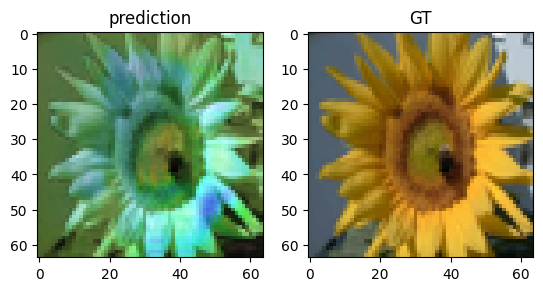

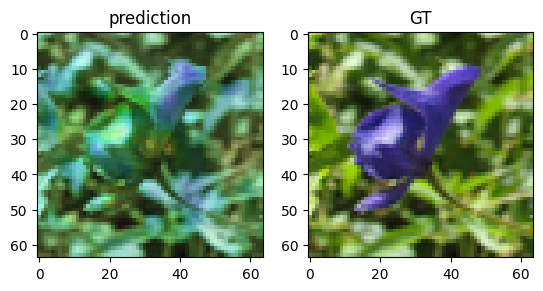

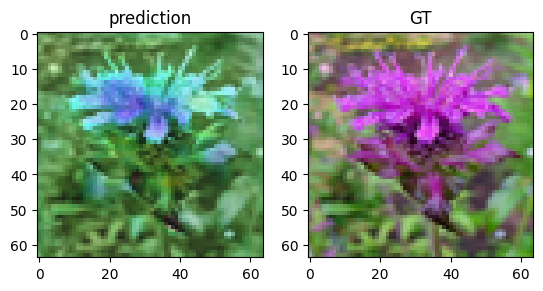

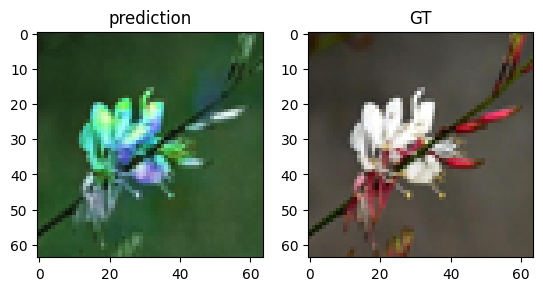

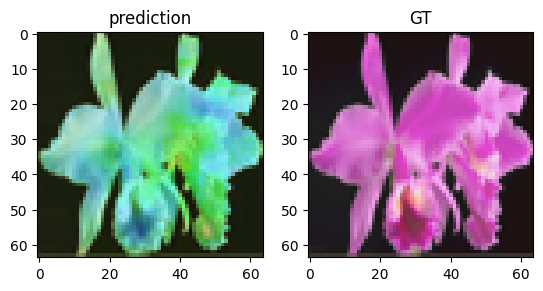

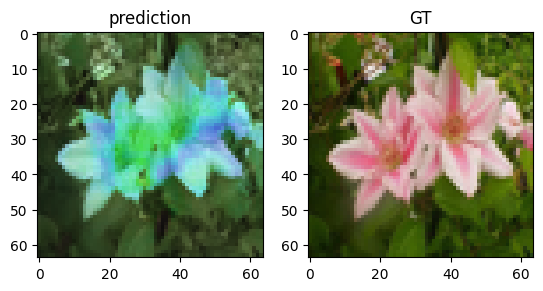

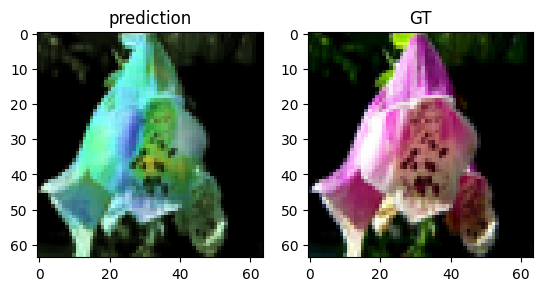

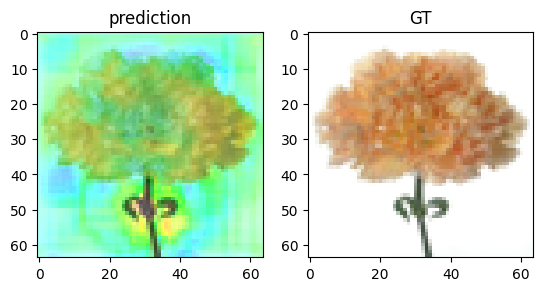

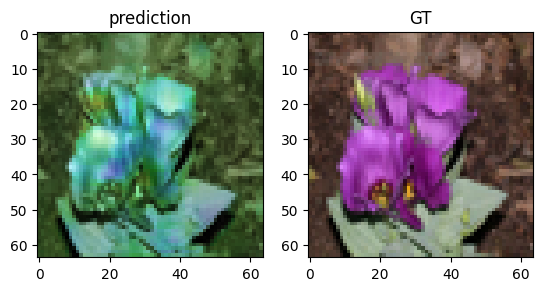

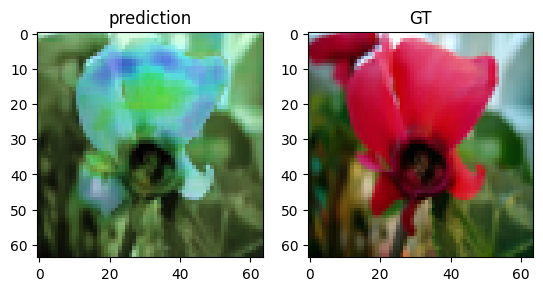

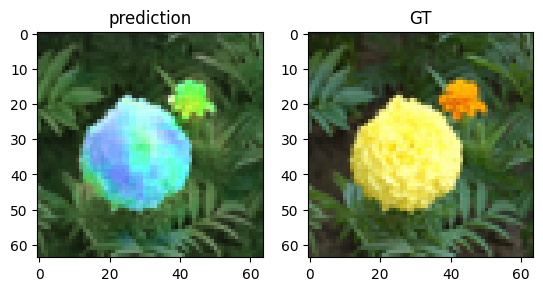

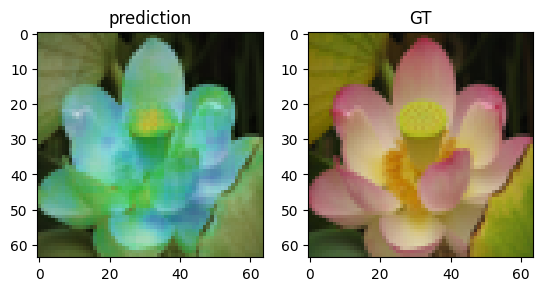

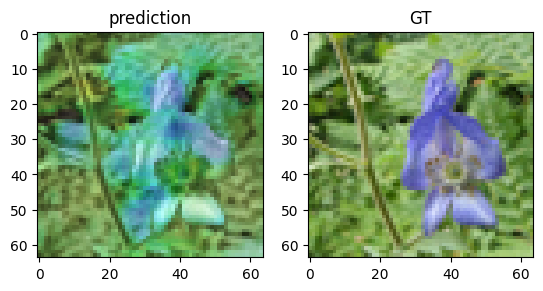

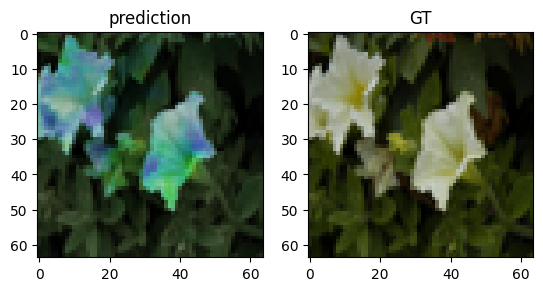

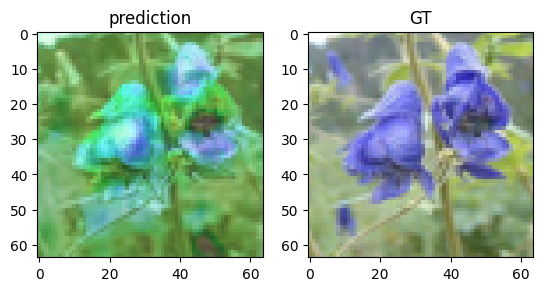

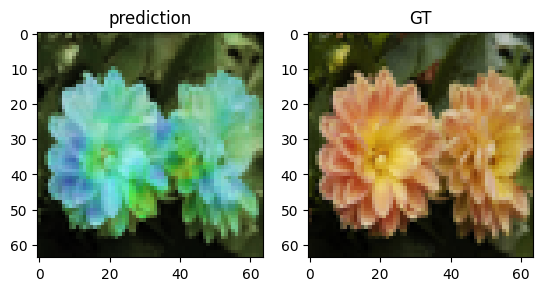

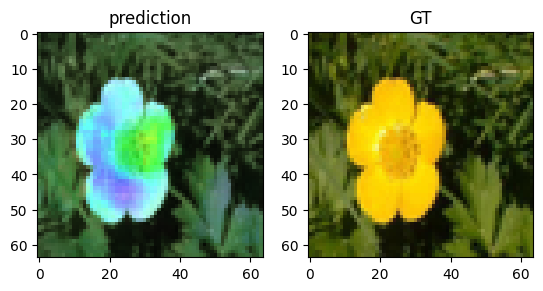

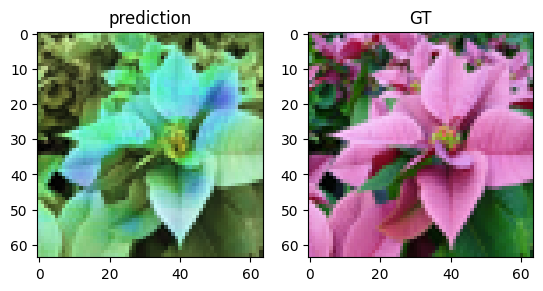

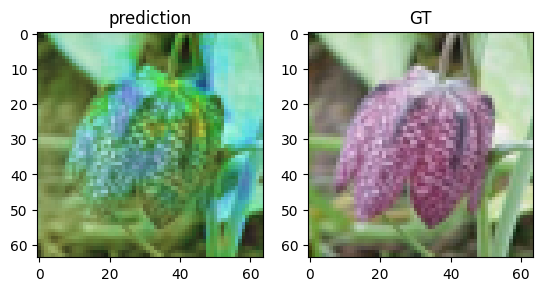

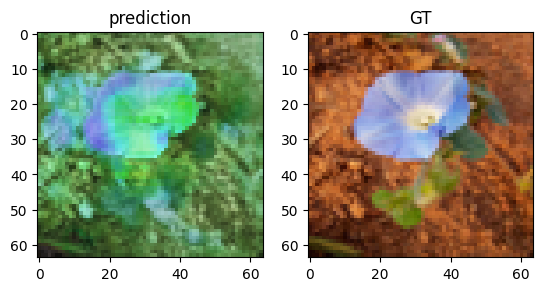

In [21]:
for in_v, gt_hs in islice(HfDatasetWrapper(dataset["test"]), 20):
    pred_hs = model.unet(in_v[None,])[0]
    plt.subplot(1, 2, 1)
    plt.imshow(visualize(in_v, pred_hs))
    plt.title("prediction")
    plt.subplot(1, 2, 2)
    plt.imshow(visualize(in_v, gt_hs))
    plt.title("GT")
    plt.show()

In [11]:
# from pytorch_lightning.tuner import Tuner
# model = UNetModel()
# trainer = pL.Trainer()
# tuner = Tuner(trainer)
# tuner.lr_find(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)